In [21]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
#from pydub import AudioSegment

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [22]:
df = pd.read_csv(r'UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [41]:
for row in df:
    print(row)

slice_file_name
fsID
start
end
salience
fold
classID
class


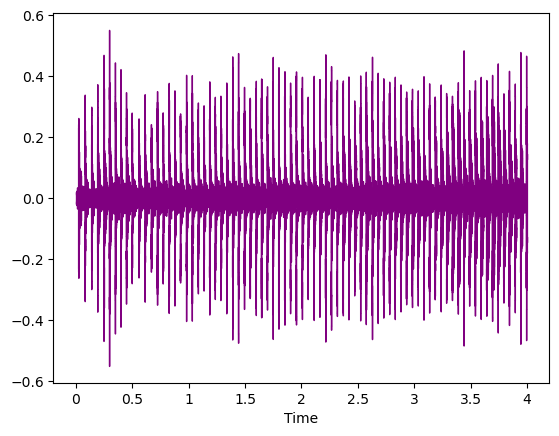

In [23]:
sample_num = 400#pick a file to display  
filename = df.slice_file_name[sample_num] #get the filename

tstart = df.start[sample_num] #define the beginning time of the signal
tend = df.end[sample_num] #define the end time of the signal

#'D:\L_IACD\SoundClassification\UrbanSound8K\audio\fold5\100263-2-0-126.wav'

path = '../UrbanSound8K/audio/fold' + str(df.fold[sample_num]) + '/' + str(filename)

y, sr = librosa.load(path)
librosa.display.waveshow(y,sr=sr, x_axis='time', color='purple', offset=0.0)

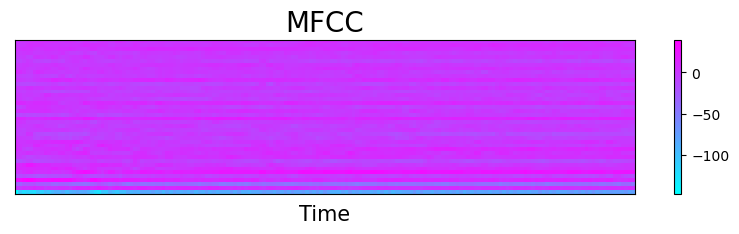

In [24]:
hop_length = 512 #the default spacing between frames
n_fft = 2550 #number of samples 

MFCCs = librosa.feature.mfcc(y=y, n_fft=n_fft, hop_length=hop_length, n_mfcc=40)

fig, ax = plt.subplots(figsize=(10, 2))
librosa.display.specshow(MFCCs,sr=sr, cmap='cool',hop_length=hop_length)
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

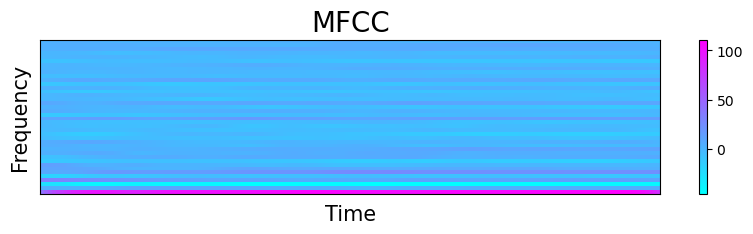

In [25]:
hop_length = round(44100 * 0.0125) 
n_fft = 2**14 #number of samples 

MFCCs = librosa.feature.mfcc(y = y, n_fft = n_fft, hop_length = hop_length, n_mfcc = 40)
    
fig, ax = plt.subplots(figsize = (10,2))
librosa.display.specshow(MFCCs, sr=sr, cmap='cool', hop_length = hop_length)
ax.set_xlabel('Time', fontsize = 15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_title('MFCC', size = 20)
plt.colorbar()
plt.show()

### Padding Audio Files

In [26]:
def zero_padded_data_nparray(audios_path, duration_secs=4, target_sample_rate=44100, files_limit=-1, verbose=False):
    files = librosa.util.find_files(audios_path)
    data_array = []

    for index, file in enumerate(files):
        if files_limit != -1 and index >= files_limit: break
        
        if verbose:
            print(f"At audio {index+1}/{len(files)}")
             
        signal, sample_rate = librosa.load(file, sr = None)
        
        # resample the sample rate to the target value of SR
        signal = librosa.resample(signal, orig_sr=sample_rate, target_sr=target_sample_rate)
        
        # zero padding
        if len(signal) < duration_secs*target_sample_rate:
            signal = np.concatenate([
                signal,
                np.zeros(shape=(duration_secs*target_sample_rate-len(signal), ))
            ])

        path = file.split("\\")
        newrow = [path[-1], signal]
        data_array.append(newrow)
        
    return data_array

In [62]:
def get_features(df_in, audio):
    features = [] # list to save features
    labels = [] # list to save labels
    
    for index in range(len(audio)):
        # get the filename        
        filename = audio[index][0]

        # find correspondig row in df_in
        row = df_in.loc[df_in["slice_file_name"] == filename]

        # get fold
        fold = row['fold']

        #save labels
        label = row.iloc[0,6] 
      
        hop_length = round(44100 * 0.0125)
        n_fft = 2**14 #number of samples 
        data = np.array([librosa.feature.mfcc(y = audio[index][1], n_fft = n_fft, hop_length = hop_length, n_mfcc = 40)])
        
        features.append(data)
        labels.append(label)

    output = np.concatenate(features, axis = 0)
    return(np.array(output), labels)


In [63]:
fold_path = "../UrbanSound8K/audio/fold1/"
audio = zero_padded_data_nparray(fold_path)

X,y = get_features(df, audio)

In [65]:
# Normalizeing data
X = np.array((X - np.min(X)) / (np.max(X) - np.min(X)))
X = X / np.std(X)
y = np.array(y)

In [66]:
y

array([3, 3, 3, 3, 6, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 8, 8, 8, 8, 9, 9, 9,
       9, 9, 9, 9, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 3, 5, 5, 5, 5, 5, 5, 5, 5, 6, 9, 9, 9, 9, 9, 9, 3, 3, 3, 3,
       0, 3, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 9, 9, 9,
       9, 9, 9, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 9, 9, 9, 9, 9, 9, 4, 4,
       5, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 3, 2, 2, 2, 1, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

In [68]:
b = np.zeros((y.size, y.max() +1))
b[np.arange(y.size), y] = 1

In [74]:
y = b

In [75]:
#Split twice to get the validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 123)

#Print the shapes
X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val)

((558, 40, 321), (175, 40, 321), (140, 40, 321), 558, 175, 140)

### Building the RNN


#### Adding Layers

In [77]:
input_shape = (40, 321)# shape of X_train

model = keras.Sequential()

model.add(layers.LSTM(128, input_shape = input_shape))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(48, activation = 'relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

NotImplementedError: Cannot convert a symbolic Tensor (lstm_2/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

#### Compile the Model

The **Adam** optimizer manages the learning rate for stochastic gradient descent. The loss function is **SparseCategoricalCrossentropy**, which is used when each sample belongs to one label, as opposed to more than one, and it’s not binary classification. 

In [ ]:
model.compile(optimizer = 'adam', loss = 'SparseCategoricalCrossentropy', metrics=['acc'])

#### Fit the Model

In [ ]:
a = model.fit(X_train, y_train, epochs = 50, batch_size = 10, validation_data = (X_val, y_val), shuffle = False)

Epoch 1/50
56/56 [==============================] - 10s 64ms/step - loss: 2.3607 - acc: 0.0968 - val_loss: 2.3023 - val_acc: 0.1071
Epoch 2/50
56/56 [==============================] - 2s 27ms/step - loss: 2.2969 - acc: 0.1004 - val_loss: 2.2972 - val_acc: 0.1000
Epoch 3/50
56/56 [==============================] - 2s 33ms/step - loss: 2.2917 - acc: 0.1183 - val_loss: 2.2858 - val_acc: 0.0929
Epoch 4/50
56/56 [==============================] - 2s 39ms/step - loss: 2.2909 - acc: 0.0896 - val_loss: 2.2889 - val_acc: 0.1000
Epoch 5/50
56/56 [==============================] - 2s 41ms/step - loss: 2.2646 - acc: 0.1290 - val_loss: 2.2918 - val_acc: 0.0857
Epoch 6/50
56/56 [==============================] - 2s 36ms/step - loss: 2.2734 - acc: 0.1254 - val_loss: 2.2852 - val_acc: 0.0929
Epoch 7/50
56/56 [==============================] - 5s 83ms/step - loss: 2.2661 - acc: 0.1219 - val_loss: 2.2857 - val_acc: 0.0929
Epoch 8/50
56/56 [==============================] - 5s 84ms/step - loss: 2.2797 - 

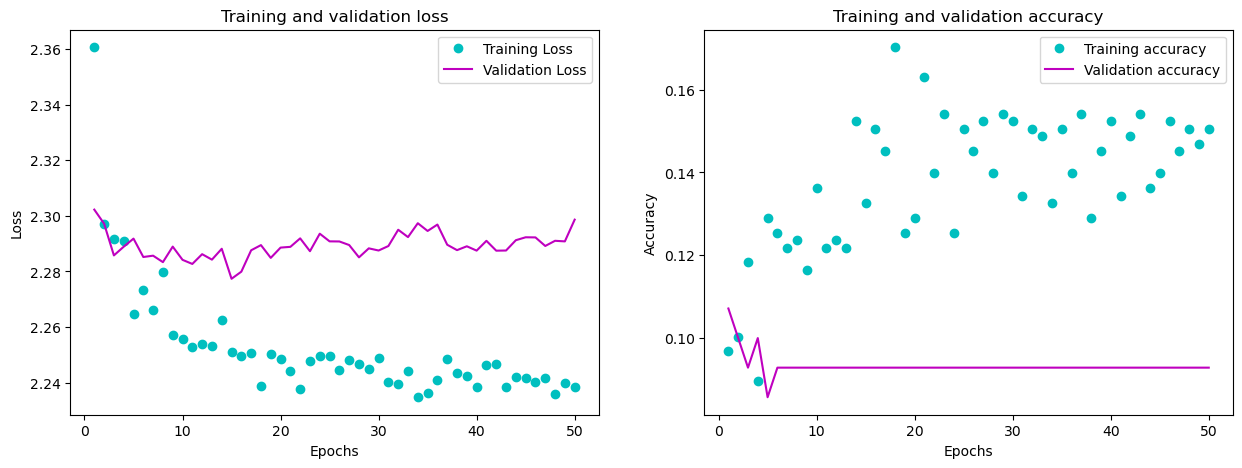

In [ ]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict = a.history

loss_values=history_dict['loss']
acc_values=history_dict['acc']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_acc']
epochs = range(1,51)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [ ]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ', tf.math.confusion_matrix(y_test, np.argmax(y_pred, axis = 1)))

6/6 [==============================] - 1s 12ms/step
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0  0 17  0  0]
 [ 0  0  0  0  0  0  0 20  0  0]], shape=(10, 10), dtype=int32)


In [ ]:
'''input_shape=(128,321)

model = tf.keras.Sequential()
model.add(layers.LSTM( 20,input_shape=input_shape))
model.add(layers.Dense(24, activation='softmax'))

model.summary()'''

"input_shape=(128,321)\n\nmodel = tf.keras.Sequential()\nmodel.add(layers.LSTM( 20,input_shape=input_shape))\nmodel.add(layers.Dense(24, activation='softmax'))\n\nmodel.summary()"

In [ ]:
'''model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_val, y_val), shuffle=False)'''

"model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['acc'])\nhistory = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_val, y_val), shuffle=False)"